# Anime or Adult Anime?

This is a personal project inspired by course work for text processing and machine learning. It is influenced by the binary comparison of spam and ham, and engages with an area many are interested in.


This project deploys a variety of text processing and machine learning tools to investigate whether there's any differences between the summaries of Anime and Adult Anime. The main intention was of personal development in terms of data. However, there is no doubt an interest of the differences between these two bodies of work. Do certain genres engages more with wordplay than the other genre? Do certain words populate a genre more than the others? These questions are the main tenents of this project.




In [2]:
# Import required libraries
import requests
import json
import pandas as pd
import random
import time
import numpy as np 
from statistics import mode
from collections import Counter
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import requests
import en_core_web_sm
nlp = en_core_web_sm.load()
import time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

## Define functions

scrap_mal: Feed in a url anime catalouge page from MyAnimeList to output a dataframe of all needed details - (title, summary)
clean_mal: Perform cleaning text cleaning such as stop_words removal and other unessarary clutter.  

In [3]:
def scrap_mal(url, genre):

    # Get request and parse through html parser
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')

    # Retreive blocks from desired subjects
    blocks = soup.find_all(class_= 'js-anime-category-producer')
    first_row = True
    first_fifty = 0
    anime_dict = {}

    # Going through each block in the whole website's catalouge
    for block in blocks:
        print('Getting item ' + str(first_fifty))
        if first_fifty < 50:
            if first_row:

                # Find the title and synopsis from each block and append to dictionary
                anime_dict['title'] = [block.find(class_='h2_anime_title').text]
                anime_dict['synopsis'] = [block.find(class_='preline').text]
                first_row = False
            else:
                anime_dict['title'].append(block.find(class_='h2_anime_title').text)
                anime_dict['synopsis'].append(block.find(class_='preline').text)
        else:
            # After 50 titles are retrieved, break from loop
            break
        first_fifty = first_fifty + 1

        # Convert to dataframe and categorised according to user
        df = pd.DataFrame(anime_dict)
        df['type'] = str(genre)

    return df
    

In [4]:
# Remove stop words from each synopsis. And appending non-stop words individually into a dictionary separated by title.
def clean_mal(dataframe):

    # Go through each synopsis and separate by paragraph and extract first element (paragrpah)
    for index in range(0,len(dataframe)):
        dataframe['synopsis'][index] = dataframe['synopsis'][index].split('\r\n')[0]

    # Remove unfit synopsis.
    remove_row = [len(item)>20 for item in dataframe['synopsis']]
    dataframe = dataframe[remove_row]

    words = dataframe['synopsis']
    filtered_sentences = {}
    index = 0

    for synopsis in words:

        # Initialise with nlp    
        my_doc = nlp(synopsis)
        token_list = []
        
        # Convert all words in each synopsis to text
        for word in my_doc:
            token_list.append(word.text)

        # For each word in a synopsis, determine whether current element is a stopword
        # If not, append word into dictionary keyed by index
        for word in token_list:
            lexeme = nlp.vocab[word]

            if index not in filtered_sentences:
                if lexeme.is_stop == False:
                    filtered_sentences[index] = [word]

            else:
                if lexeme.is_stop == False:
                    filtered_sentences[index].append(word)

        # Move to next synopsis
        index = index + 1

        # Join the dictionary entries into a single string instead of arrays for each title.
    for key in filtered_sentences:
        filtered_sentences[key] = ' '.join(filtered_sentences[key])

    # Convert to column in dataframe by exporting dictionary ignoring the key with pd.Series
    dataframe['updated_synopsis'] = pd.Series(filtered_sentences)
    # Remove punctuation
    dataframe['updated_synopsis'] = dataframe['updated_synopsis'].str.replace(r'[^\w\s]+', '')

    return dataframe


Scrap from pages

In [ ]:
# Scrap from desired hentai and anime page
hentai_df = scrap_mal("https://myanimelist.net/anime/genre/12/Hentai", "hentai")

# Avoid MAL request overload
time.sleep(3)

anime_df = scrap_mal("https://myanimelist.net/anime/season/2010/summer", "anime")

In [6]:
# Concatenate dataframes
data = pd.DataFrame(pd.concat([anime_df, hentai_df], axis =0, ignore_index=  True))

## Data Cleaning

The cleaning process primes the data for machine learning. The aftermath will produce unreadable synopsies, but will be important for rudimentary observation and models. Titles with inadequate synopsis will be removed. Furthermore, to limit process overload, only the first paragraph will be extracted.

## Exploration

In [ ]:
# Deploy function to clean and transform data
data = clean_mal(data)

# Download final version
data.to_csv('combined_mal.csv')

In [8]:
# Filter through each synopsis and merge into one big string separted by 'type'
aggregate = data.groupby('type').agg({'updated_synopsis' : lambda x: x.str.cat(sep = ' ')})

agg_a = aggregate['updated_synopsis'].anime
agg_h = aggregate['updated_synopsis'].hentai

# Gather most frequent terms in each category
common_words_hentai = [word for word, word_count in Counter(agg_h.split()).most_common(15)]
common_words_anime = [word for word, word_count in Counter(agg_a.split()).most_common(15)]

['school', 'sexual', 'time', 'high', 'men', 'beautiful', 'women', 'years', 'student', 'finds', 'girl', 'ends', 'Airi', 'girls', 'day']
['school', 'year', 'girl', 'new', 'Pico', 'Japan', 'young', 'life', 'day', 'student', 'love', 'team', 'club', 'old', 'high']


In [9]:
from collections import Counter
anime_counter = Counter(agg_a.split())
hentai_counter = Counter(agg_h.split())
anime_counter = anime_counter.most_common(10)
hentai_counter = hentai_counter.most_common(10)

index = 0

#  Convert the tuples in a dataframe and augment the titles with its appropriate genre
for item in anime_counter:
    hentai_counter[index] = hentai_counter[index] + ('hentai',)
    anime_counter[index] = anime_counter[index] + ('anime',)
    index = index + 1

In [ ]:
# Convert the dataframe and produce frequency table
word_count = pd.DataFrame(anime_counter + hentai_counter, columns = ['word', 'counts', 'type'])
word_count.sort_values(by = ['counts'], ascending = False)

In [188]:
word_count.sort_values(by = ['counts'], ascending = False)

,word,counts,type
10,school,15,hentai
11,sexual,14,hentai
0,school,13,anime
1,year,11,anime
2,girl,9,anime
12,time,9,hentai
14,men,8,hentai
13,high,8,hentai
4,Pico,7,anime
16,women,7,hentai


Within this (or perhaps in general) there is a focus on school and highschool settings within both genres. One of the stop words for adult anime is clearly distinctive. Below are graphs to visualise these words.

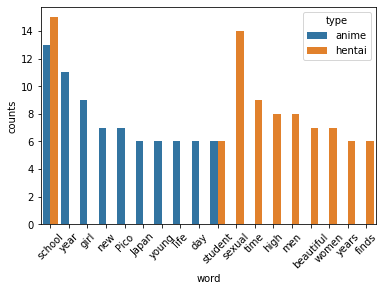

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data = word_count, x = 'word', y = 'counts', hue = 'type')
plt.xticks(rotation = 45)
plt.show()

Combined


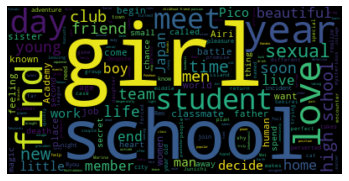

Anime


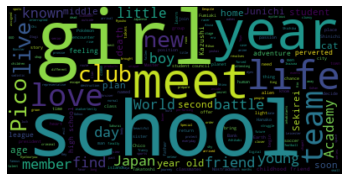

Hentai


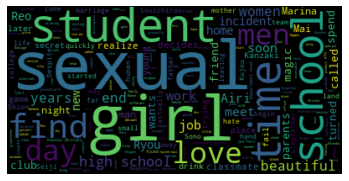

In [45]:
from wordcloud import WordCloud, ImageColorGenerator

whole_text = data['updated_synopsis'].agg(lambda x: x.str.cat(sep = ' '))

list = [whole_text, aggregate['updated_synopsis'].anime, aggregate['updated_synopsis'].hentai]
list_name = ['Combined','Anime','Hentai']
for item, item_name in zip(list, list_name):
    print(item_name)
    wordcloud = WordCloud().generate(item)
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()


Looking at these visualisations, the school setting is indeed popular. Perhaps through years of experimentation, companies have picked up on certain tendencies of the fanbase. Therefore choosing this setting. In addition, in both anime genres the focus on 'girl' is interesting. This catering is not directed towards any gender, yet might indicate that a focus on girls sells better than boys. This cross-over in settings and character type may colllude with the machine learning model as the distinctive beside certains words may not be powerful enough. From these assumptions, it is likely the models may have an ok prediction accuracy but not exceptional. Lets test to find out.

# Machine Learning

To deploy machine learning classifiers, the data must be processed. The first step is creating our feature vecter through CountVectorizer. This then gets processed to our term frequency processor. Finally this gets pipied to our classifier.

In [147]:
# Get train test split
X_train, X_test, y_train, y_test = train_test_split(data.updated_synopsis, data.type, test_size=0.15, random_state = 2023)
X_train = X_train.values.astype('U')
X_test = X_test.values.astype('U')


In [112]:
# Creating pipelines each classifier.
mnb = Pipeline([('vect', CountVectorizer(lowercase=False, ngram_range = (1,1))),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())
               ])


svm = Pipeline([('vect', CountVectorizer(lowercase=False)),
                ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC(C=0.1, penalty='l2'))
               ])

rf = Pipeline([('vect', CountVectorizer(lowercase=False, ngram_range = (1,1))),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier())
               ])

logreg = Pipeline([('vect', CountVectorizer(lowercase=False, ngram_range = (1,1))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression())
               ])


Repeated cross validation will be deployed to gain a more robust gauge on the differences as gathered by the machine learning models.

In [182]:

# evaluate a logistic regression model using repeated k-fold cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats = 10)
mnb_scores = cross_val_score(rf, data['synopsis'], data['type'],cv = cv, n_jobs = - 1)
svm_scores = cross_val_score(rf, data['synopsis'], data['type'],cv = cv, n_jobs = - 1)
rf_scores = cross_val_score(rf, data['synopsis'], data['type'],cv = cv, n_jobs = - 1)
logreg_scores = cross_val_score(rf, data['synopsis'], data['type'],cv = cv, n_jobs = - 1)

In [183]:
print('mnb accuracy: %s' % mean(mnb_scores))
print('svm accuracy: %s' % mean(svm_scores))
print('rf accuracy: %s' % mean(rf_scores))
print('logreg accuracy: %s' % mean(logreg_scores))

mnb accuracy: 0.6268888888888889
svm accuracy: 0.608111111111111
rf accuracy: 0.605
logreg accuracy: 0.6054444444444443


All models lie within the 60-63 accuracy range. This indicates that the distinctive as seen by the models is not strong enough for overepresentation. Could this mean both genre read similarly?  Reguardless, because the mnb performs the best with an accuracy of 63%, a search grid pipeline will be used optimise the accuracy.

In [184]:
param_grid = [{'vect__binary': [True],
               'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': [True, False]
              },
              {'vect__binary': [False],
               'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': [True, False]
              }
             ]

gs_mnb = GridSearchCV(mnb, param_grid)
gs_mnb.fit(data['synopsis'], data['type'])
print('\nMNB best params:\n', gs_mnb.best_params_)


MNB best params:
 {'tfidf__use_idf': False, 'vect__binary': False, 'vect__ngram_range': (1, 1)}


In [186]:
gs_mnb.best_score_

0.631578947368421

The model barely increases. Therefore retaining the assumption that a machine finds it somewhat difficult to accuracy find strong differences.

# Conclusion

Perhaps it is a result of selection bias with the year or animes, but it is clear the machine used is not otimized enough to recognise and differentiate the summaries provided by adult anime and anime. Yet, there is an above 50% accuracy score, and therefore hints that there could be potential. 

Reguardless, as a passion project (a future candidate for optimization) it helped me understand text processing and strong numerous tools can be deployed to clean text data and how certain manipulations can potentially bostler a model to readily predict accurately. 
